In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.pipeline import Pipeline, make_pipeline

sys.path.insert(0, '../python/')
from helpers import *

plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 14})
warnings.filterwarnings('ignore')

In [2]:
# features
# - hotel: [Resort Hotel, City Hotel] => [0, 1]
# - total_nights: [1, 2, 3, 4, 5, 6, 7, 8] => dummies
# - total_special_requests: [0, 1, 2] => dummies
# - market_segment: [Corporate, Online TA, Offline TA/TO, Direct, Groups] => dummies
# - room_difference: [0, 1]
# - party_size: [1, 2, 3] => dummies
# - booking_changes: [0, 1]


In [3]:
data = pd.read_csv('../../data/train/cancellations.csv')

# Clean and Prepare Data for Tuning

In [4]:
feats = ['hotel','market_segment', 'total_of_special_requests', 
         'total_nights', 'room_difference', 'party_size', 'booking_changes']
dummy_cols = ['total_nights', 'total_of_special_requests', 'market_segment', 'party_size']

X = data[feats].copy()

X.replace(['Resort Hotel', 'City Hotel'], [0, 1], inplace=True)
X.loc[np.argwhere((X['total_nights'] >= 8).values).flatten(), 'total_nights'] = 8
X.loc[np.argwhere((X['total_of_special_requests'] >= 2).values).flatten(), 'total_of_special_requests'] = 2
X.loc[np.argwhere(X['market_segment'].isin(['Aviation', 'Complementary']).values).flatten(), 'market_segment'] = 'Corporate'
X.loc[np.argwhere((X['party_size'] >= 3).values).flatten(), 'party_size'] = 3
X.loc[np.argwhere((X['booking_changes'] >= 1).values).flatten(), 'booking_changes'] = 1

X = pd.get_dummies(X, columns=dummy_cols).to_numpy()
y = data[['is_canceled']].to_numpy()

# Random Forest Gridsearch

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 12.1min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 19.4min finished


best parameters: {'estimator__criterion': 'gini', 'estimator__max_depth': 3, 'estimator__max_features': 'sqrt', 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 200, 'estimator__random_state': 1}


Text(0, 0.5, 'Precision/Recall')

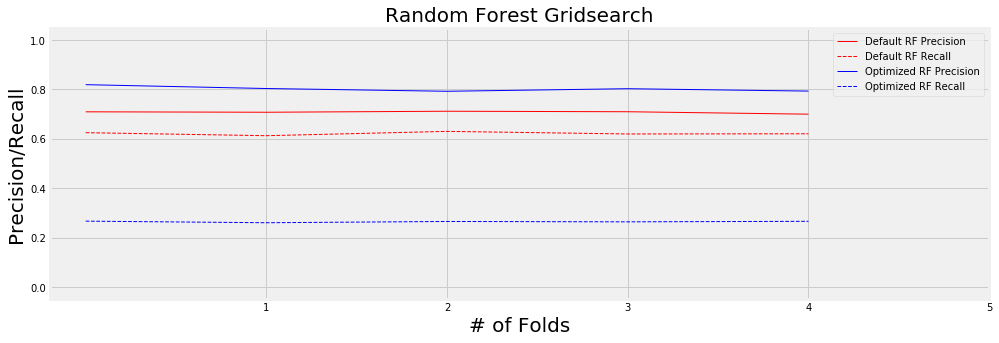

In [5]:
pipe = Pipeline(steps=[('estimator', RandomForestClassifier())])


params = {'estimator__max_depth': [3, None],
          'estimator__max_features': ['sqrt', 'log2', None],
          'estimator__n_estimators': [75, 100, 150, 200, 300],
          'estimator__criterion': ['gini', 'entropy'],
          'estimator__min_samples_leaf': [1, 2],
          'estimator__random_state': [1]}

grid = GridSearchCV(pipe, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring=['recall', 'precision'], 
                    refit='precision')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

best_rf_model = grid.best_estimator_
default_rf = RandomForestClassifier()

models = [default_rf, best_rf_model]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Default RF', 'Optimized RF'], sampling_method=None )
ax.set_title('Random Forest Gridsearch', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('Precision/Recall', fontsize=20)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 29.8min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 53.3min finished


best parameters: {'estimator__loss': 'deviance', 'estimator__max_depth': 3, 'estimator__max_features': None, 'estimator__min_samples_leaf': 1, 'estimator__n_estimators': 300, 'estimator__random_state': 1}


Text(0, 0.5, 'Precision/Recall')

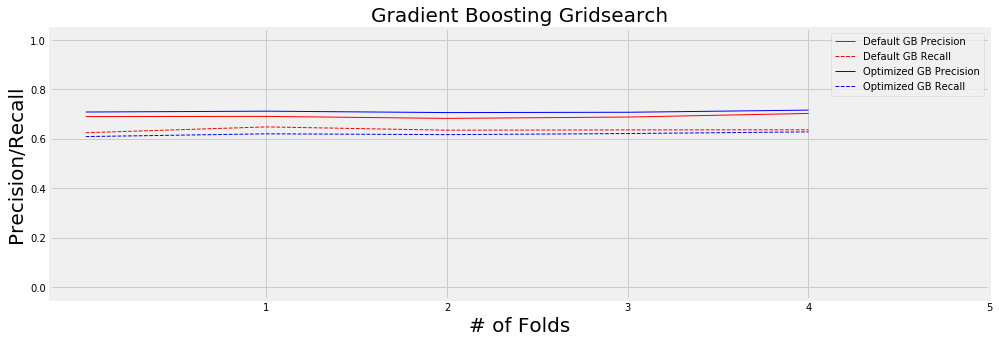

In [8]:
pipe = Pipeline(steps=[('estimator', GradientBoostingClassifier())])


params = {'estimator__max_depth': [3, None],
          'estimator__max_features': ['sqrt', 'log2', None],
          'estimator__n_estimators': [75, 100, 150, 200, 300],
          'estimator__loss': ['deviance', 'exponential'],
          'estimator__min_samples_leaf': [1, 2],
          'estimator__random_state': [1]}

grid = GridSearchCV(pipe, 
                    params, 
                    n_jobs=-1,
                    verbose=True,
                    scoring=['recall', 'precision'], 
                    refit='precision')
grid.fit(X, y)

print("best parameters:", grid.best_params_)

best_gb_model = grid.best_estimator_
default_gb = GradientBoostingClassifier()

models = [default_gb, best_gb_model]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Default GB', 'Optimized GB'], sampling_method=None )
ax.set_title('Gradient Boosting Gridsearch', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('Precision/Recall', fontsize=20)

Text(0, 0.5, 'Precision/Recall')

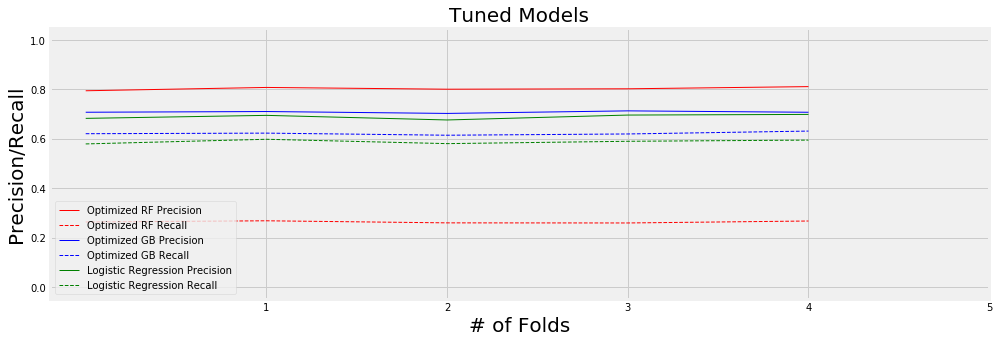

In [9]:
#best_rf_model = RandomForestClassifier(criterion='gini', max_depth=3, 
#                                       max_features='sqrt', n_estimators=200, 
#                                       min_samples_leaf=1)

# best_gb_model = GradientBoostingClassifier(loss='', 
#                                            max_depth=, 
#                                            max_features='', 
#                                            n_estimators=,
#                                            min_samples_leaf=, learning_rate=0.01)

models = [best_rf_model, best_gb_model, LogisticRegression()]


fig, ax = plt.subplots(figsize=(15, 5))
plot_cross_val(models, X, y, ax, names=['Optimized RF', 'Optimized GB', 'Logistic Regression'], sampling_method=None )
ax.set_title('Tuned Models', fontsize=20)
ax.legend()
ax.set_ylim(-0.05, 1.05)
ax.set_xticks([1, 2, 3, 4, 5])
ax.set_xlabel('# of Folds', fontsize=20)
ax.set_ylabel('Precision/Recall', fontsize=20)